2025-08-20 15:03:25,025 db.db INFO Creating database engine


Found 4575 date mention records from 233 unique files
Found 7435 total date mentions
Found 2526 unique dates


2025-08-20 15:04:18,375 matplotlib.category INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\adankert\AppData\Local\Temp\ipykernel_22100\2773991588.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_dates_df, x='Date', y='Mentions',
2025-08-20 15:04:18,539 matplotlib.category INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\adankert\AppData\Local\Temp\ipykernel_22100\2773991588.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` 


Summary Statistics:
Average mentions per date: 2.94
Files analyzed: 233
Most mentioned date: ('2025-08-20', 128)
Granularity breakdown: {'day': 4575}


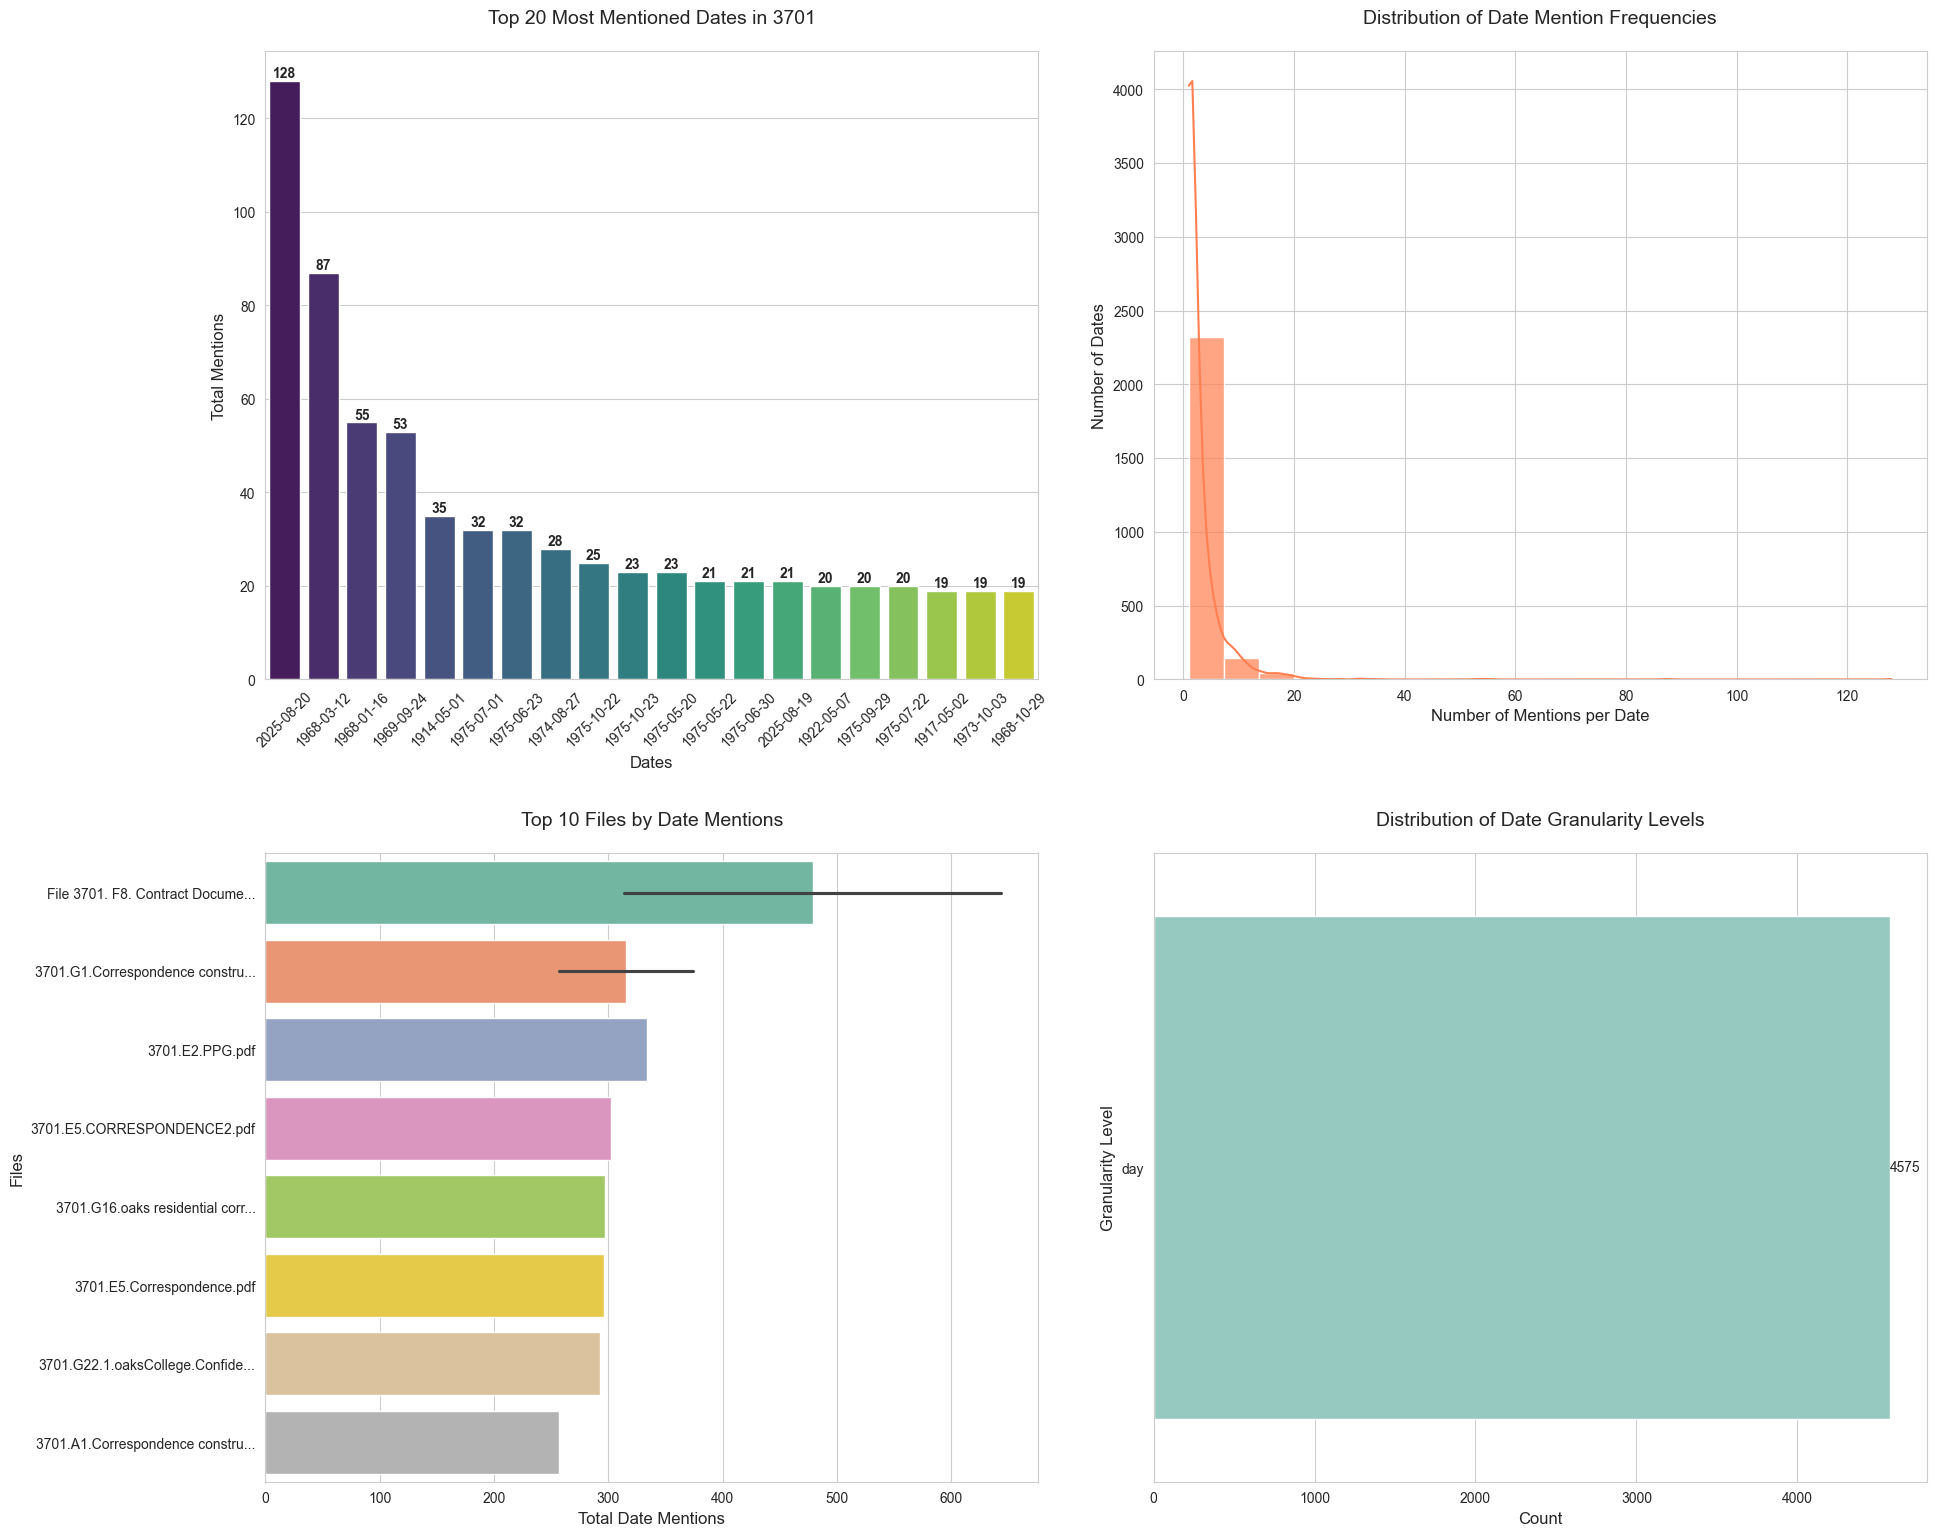

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from pathlib import Path
from typing import Tuple, Optional
from db.db import get_db_engine
from db.models import FileLocation, FileDateMention, File
from utils import extract_server_dirs
from sqlalchemy.orm import sessionmaker

# Set seaborn style
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

def date_mentions_summary_viz_for_location(directory_path: str, 
                                   base_mount: str,
                                   limit_top_dates: int = 20) -> Tuple[Counter, plt.Figure]:
    """
    Creates plot where subplots show summary statistics of date mentions.

    Parameters
    ----------
    directory_path : str
        The directory path to analyze (will be converted to server directory format)
    base_mount : str
        The local mount point for the records share (e.g., "N:\\PPDO\\Records")
    limit_top_dates : int
        Number of top dates to show in the bar chart (default: 20)
    
    Returns
    -------
    Tuple[Counter, plt.Figure]
        Counter of date mentions and matplotlib figure
    """
    
    # Convert directory path to server directory format for database lookup
    try:
        server_dir_prefix = extract_server_dirs(directory_path, base_mount)
    except ValueError as e:
        print(f"Error: {e}")
        return Counter(), plt.figure()
    
    # Create database session
    
    try:
        df = pd.DataFrame()
        with sessionmaker(bind=get_db_engine())() as session:
            # Query for files in the directory and subdirectories using SQLAlchemy
            query_results = session.query(
                FileLocation.id,
                FileLocation.filename,
                FileLocation.file_server_directories,
                FileDateMention.mention_date,
                FileDateMention.granularity,
                FileDateMention.mentions_count,
                FileDateMention.extractor
            ).join(
                File, FileLocation.file_id == File.id
            ).join(
                FileDateMention, File.hash == FileDateMention.file_hash
            ).filter(
                FileLocation.file_server_directories.like(f"{server_dir_prefix}%")
            ).order_by(
                FileDateMention.mentions_count.desc()
            ).all()
            
            if not query_results:
                print(f"No date mentions found for files in directory: {directory_path}")
                print(f"Server directory pattern searched: {server_dir_prefix}")
                fig, ax = plt.subplots(1, 1, figsize=(12, 8))
                ax.text(0.5, 0.5, f'No date mentions found in\n{directory_path}', 
                        ha='center', va='center', fontsize=16)
                ax.set_xlim(0, 1)
                ax.set_ylim(0, 1)
                ax.set_title(f'Date Mentions Analysis: {directory_path}', fontsize=14, pad=20)
                return Counter(), fig
            
            # Convert query results to DataFrame
            df = pd.DataFrame(query_results, columns=[
                'file_id', 'filename', 'file_server_directories', 
                'mention_date', 'granularity', 'mentions_count', 'extractor'
            ])
        
            print(f"Found {len(df)} date mention records from {df['filename'].nunique()} unique files")

    except Exception as e:
        print(f"Error occurred while processing DataFrame: {e}")
        return Counter(), plt.figure()

    try:
        # Aggregate date mentions by mention_date
        date_counter = Counter()
        for _, row in df.iterrows():
            # Convert date to string for the counter
            date_str = row['mention_date'].strftime('%Y-%m-%d')
            date_counter[date_str] += row['mentions_count']
        
        print(f"Found {sum(date_counter.values())} total date mentions")
        print(f"Found {len(date_counter)} unique dates")
        
        # Create visualization with seaborn
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
        
        # 1. Bar chart of top dates using seaborn
        if date_counter:
            top_dates = date_counter.most_common(limit_top_dates)
            top_dates_df = pd.DataFrame(top_dates, columns=['Date', 'Mentions'])
            
            sns.barplot(data=top_dates_df, x='Date', y='Mentions', 
                       palette='viridis', ax=ax1)
            ax1.set_title(f'Top {len(top_dates)} Most Mentioned Dates in {Path(directory_path).name}', 
                         fontsize=14, pad=20)
            ax1.set_xlabel('Dates', fontsize=12)
            ax1.set_ylabel('Total Mentions', fontsize=12)
            ax1.tick_params(axis='x', rotation=45)
            
            # Add value labels on bars
            for i, v in enumerate(top_dates_df['Mentions']):
                ax1.text(i, v + 0.1, str(v), ha='center', va='bottom', fontweight='bold')
        
        # 2. Histogram of mention frequency distribution
        frequency_counts = list(date_counter.values())
        sns.histplot(frequency_counts, bins=min(20, len(set(frequency_counts))), 
                    kde=True, color='coral', alpha=0.7, ax=ax2)
        ax2.set_xlabel('Number of Mentions per Date', fontsize=12)
        ax2.set_ylabel('Number of Dates', fontsize=12)
        ax2.set_title('Distribution of Date Mention Frequencies', fontsize=14, pad=20)
        
        # 3. Files with most date mentions
        file_mention_counts = df.groupby('filename')['mentions_count'].sum().sort_values(ascending=False).head(10)
        if not file_mention_counts.empty:
            file_df = pd.DataFrame({
                'filename': [name[:30] + '...' if len(name) > 30 else name for name in file_mention_counts.index],
                'mentions': file_mention_counts.values
            })
            
            sns.barplot(data=file_df, y='filename', x='mentions', 
                       palette='Set2', ax=ax3)
            ax3.set_title('Top 10 Files by Date Mentions', fontsize=14, pad=20)
            ax3.set_xlabel('Total Date Mentions', fontsize=12)
            ax3.set_ylabel('Files', fontsize=12)
        
        # 4. Distribution of date granularity with countplot
        if 'granularity' in df.columns:
            sns.countplot(data=df, y='granularity', palette='Set3', ax=ax4)
            ax4.set_ylabel('Granularity Level', fontsize=12)
            ax4.set_xlabel('Count', fontsize=12)
            ax4.set_title('Distribution of Date Granularity Levels', fontsize=14, pad=20)
            
            # Add value labels on bars
            for i, count in enumerate(df['granularity'].value_counts()):
                ax4.text(count + 1, i, str(count), va='center')
        else:
            ax4.text(0.5, 0.5, 'No granularity data available', 
                    ha='center', va='center', fontsize=14)
        
        plt.tight_layout(pad=3.0)
        
        # Print summary statistics
        print(f"\nSummary Statistics:")
        print(f"Average mentions per date: {sum(date_counter.values()) / len(date_counter):.2f}")
        print(f"Files analyzed: {df['filename'].nunique()}")
        print(f"Most mentioned date: {date_counter.most_common(1)[0] if date_counter else 'None'}")
        print(f"Granularity breakdown: {df['granularity'].value_counts().to_dict()}")
        
        return date_counter, fig

    except Exception as e:
        print(f"Error occurred while processing DataFrame into plot: {e}")
        return Counter(), plt.figure()

#Example usage:
base_mount = r"N:\PPDO\Records"
directory_to_analyze = r"N:\PPDO\Records\37xx   Oakes College\3701\3701"
date_counts, figure = date_mentions_summary_viz_for_location(directory_to_analyze, base_mount)
plt.show()

2025-08-20 15:20:43,388 db.db INFO Creating database engine


Found 4575 date mention records from 233 unique files


2025-08-20 15:20:44,490 matplotlib.ticker WARNING Locator attempting to generate 1747 ticks ([-27972.0, ..., 25171.0]), which exceeds Locator.MAXTICKS (1000).
2025-08-20 15:20:44,550 matplotlib.ticker WARNING Locator attempting to generate 1747 ticks ([-27972.0, ..., 25171.0]), which exceeds Locator.MAXTICKS (1000).
2025-08-20 15:20:49,458 matplotlib.ticker WARNING Locator attempting to generate 53176 ticks ([-27984.0, ..., 25191.0]), which exceeds Locator.MAXTICKS (1000).
2025-08-20 15:20:49,637 matplotlib.ticker WARNING Locator attempting to generate 1747 ticks ([-27972.0, ..., 25171.0]), which exceeds Locator.MAXTICKS (1000).
2025-08-20 15:23:35,273 matplotlib.ticker WARNING Locator attempting to generate 1747 ticks ([-27972.0, ..., 25171.0]), which exceeds Locator.MAXTICKS (1000).
2025-08-20 15:23:35,601 matplotlib.ticker WARNING Locator attempting to generate 1747 ticks ([-27972.0, ..., 25171.0]), which exceeds Locator.MAXTICKS (1000).
2025-08-20 15:23:36,251 matplotlib.ticker WAR


Summary Statistics:
Date range: 1900-01-01 to 2032-05-09
Total unique documents with date mentions: 234
Total documents mentioned across all dates: 4254
Dates with document mentions: 2526 out of 48342 (5.2%)
Average documents per day: 0.09
Maximum documents in a single day: 87


2025-08-20 15:24:53,707 matplotlib.ticker WARNING Locator attempting to generate 1747 ticks ([-27972.0, ..., 25171.0]), which exceeds Locator.MAXTICKS (1000).
2025-08-20 15:24:55,710 matplotlib.ticker WARNING Locator attempting to generate 53176 ticks ([-27984.0, ..., 25191.0]), which exceeds Locator.MAXTICKS (1000).
2025-08-20 15:24:55,878 matplotlib.ticker WARNING Locator attempting to generate 1747 ticks ([-27972.0, ..., 25171.0]), which exceeds Locator.MAXTICKS (1000).
2025-08-20 15:24:59,945 matplotlib.ticker WARNING Locator attempting to generate 1747 ticks ([-27972.0, ..., 25171.0]), which exceeds Locator.MAXTICKS (1000).
2025-08-20 15:25:01,855 matplotlib.ticker WARNING Locator attempting to generate 53176 ticks ([-27984.0, ..., 25191.0]), which exceeds Locator.MAXTICKS (1000).
2025-08-20 15:25:01,987 matplotlib.ticker WARNING Locator attempting to generate 1747 ticks ([-27972.0, ..., 25171.0]), which exceeds Locator.MAXTICKS (1000).
2025-08-20 15:25:14,646 matplotlib.ticker WA

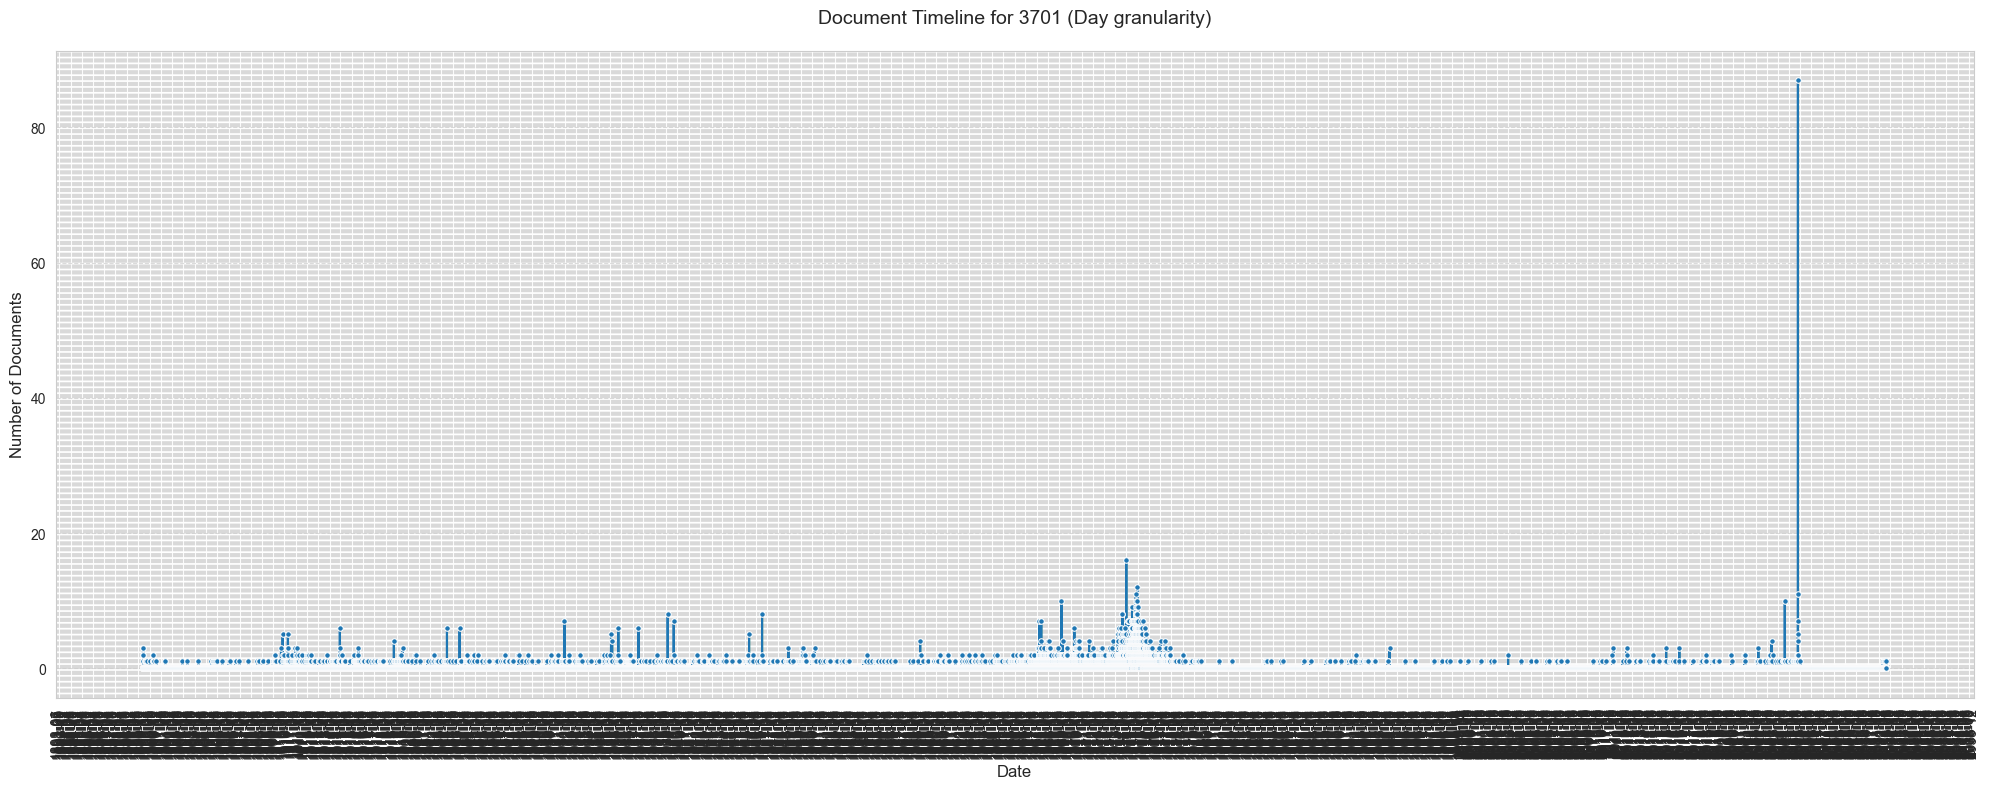

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from pathlib import Path
from typing import Tuple, Optional
from db.db import get_db_engine
from db.models import FileLocation, FileDateMention, File
from utils import extract_server_dirs
from sqlalchemy.orm import sessionmaker
import matplotlib.dates as mdates

def document_date_timeline_viz(directory_path: str, 
                             base_mount: str,
                             date_granularity: str = "day",
                             start_date: Optional[str] = None,
                             end_date: Optional[str] = None) -> Tuple[pd.DataFrame, plt.Figure]:
    """
    Creates a timeline plot showing the number of documents that mention each date sequentially.
    Includes zero counts for dates that aren't mentioned.
    
    Parameters
    ----------
    directory_path : str
        The directory path to analyze (will be converted to server directory format)
    base_mount : str
        The local mount point for the records share (e.g., "N:\\PPDO\\Records")
    date_granularity : str
        The granularity level for the timeline ("day", "month", or "year")
    start_date : Optional[str]
        Optional start date for the timeline in 'YYYY-MM-DD' format
    end_date : Optional[str]
        Optional end date for the timeline in 'YYYY-MM-DD' format
    
    Returns
    -------
    Tuple[pd.DataFrame, plt.Figure]
        DataFrame with document counts per date and matplotlib figure
    """
    
    # Convert directory path to server directory format for database lookup
    try:
        server_dir_prefix = extract_server_dirs(directory_path, base_mount)
    except ValueError as e:
        print(f"Error: {e}")
        return pd.DataFrame(), plt.figure()
    
    # Create database session
    try:
        with sessionmaker(bind=get_db_engine())() as session:
            # Query for files in the directory and subdirectories using SQLAlchemy
            query = session.query(
                FileLocation.id,
                FileLocation.filename,
                File.hash,
                FileDateMention.mention_date,
                FileDateMention.granularity
            ).join(
                File, FileLocation.file_id == File.id
            ).join(
                FileDateMention, File.hash == FileDateMention.file_hash
            ).filter(
                FileLocation.file_server_directories.like(f"{server_dir_prefix}%")
            )
            
            # Apply date range filters if provided
            if start_date:
                start_dt = pd.to_datetime(start_date)
                query = query.filter(FileDateMention.mention_date >= start_dt)
                
            if end_date:
                end_dt = pd.to_datetime(end_date)
                query = query.filter(FileDateMention.mention_date <= end_dt)
            
            query_results = query.all()
            
            if not query_results:
                print(f"No date mentions found for files in directory: {directory_path}")
                print(f"Server directory pattern searched: {server_dir_prefix}")
                fig, ax = plt.subplots(1, 1, figsize=(12, 8))
                ax.text(0.5, 0.5, f'No date mentions found in\n{directory_path}', 
                        ha='center', va='center', fontsize=16)
                ax.set_xlim(0, 1)
                ax.set_ylim(0, 1)
                ax.set_title(f'Document Date Timeline: {directory_path}', fontsize=14, pad=20)
                return pd.DataFrame(), fig
            
            # Convert query results to DataFrame
            df = pd.DataFrame(query_results, columns=[
                'file_id', 'filename', 'file_hash', 'mention_date', 'granularity'
            ])
        
            print(f"Found {len(df)} date mention records from {df['filename'].nunique()} unique files")

    except Exception as e:
        print(f"Error occurred while querying database: {e}")
        return pd.DataFrame(), plt.figure()

    try:
        # Process data for timeline visualization
        # Adjust dates based on granularity
        if date_granularity == "month":
            df['date_key'] = df['mention_date'].dt.strftime('%Y-%m-01')
        elif date_granularity == "year":
            df['date_key'] = df['mention_date'].dt.strftime('%Y-01-01')
        else:  # default is day
            df['date_key'] = df['mention_date'].dt.strftime('%Y-%m-%d')
        
        # Convert back to datetime for proper sorting
        df['date_key'] = pd.to_datetime(df['date_key'])
        
        # Count unique documents per date
        doc_counts = df.groupby('date_key')['file_hash'].nunique().reset_index()
        doc_counts.columns = ['date', 'document_count']
        
        # Define date range
        if start_date:
            min_date = pd.to_datetime(start_date)
        else:
            min_date = doc_counts['date'].min()
            
        if end_date:
            max_date = pd.to_datetime(end_date)
        else:
            max_date = doc_counts['date'].max()
        
        # Create complete date range with appropriate frequency
        if date_granularity == "month":
            date_range = pd.date_range(start=min_date, end=max_date, freq='MS')  # Month start
        elif date_granularity == "year":
            date_range = pd.date_range(start=min_date, end=max_date, freq='YS')  # Year start
        else:  # default is day
            date_range = pd.date_range(start=min_date, end=max_date, freq='D')
        
        # Create a complete timeline DataFrame with all dates in range
        timeline_df = pd.DataFrame({'date': date_range})
        
        # Merge with document counts and fill missing values with 0
        timeline_df = timeline_df.merge(doc_counts, on='date', how='left').fillna(0)
        timeline_df['document_count'] = timeline_df['document_count'].astype(int)
        
        # Calculate figure dimensions based on the number of data points
        fig_height = 8  # Base height
        
        # For many data points, make the figure wider
        if len(timeline_df) > 100:
            fig_width = 20  # Extended width for many points
        else:
            fig_width = 15  # Standard width
        
        # Create figure and axis
        fig, ax = plt.subplots(figsize=(fig_width, fig_height))
        
        # Plot the timeline
        sns.lineplot(data=timeline_df, x='date', y='document_count', 
                    marker='o', linewidth=1.5, markersize=4, ax=ax)
        
        # Format the plot
        location_name = Path(directory_path).name
        ax.set_title(f'Document Timeline for {location_name} ({date_granularity.capitalize()} granularity)', 
                    fontsize=14, pad=20)
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Number of Documents', fontsize=12)
        
        # Format x-axis dates based on granularity
        if date_granularity == "year":
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
            plt.xticks(rotation=0)
        elif date_granularity == "month":
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            plt.xticks(rotation=45)
        else:  # default is day
            # For daily data with many points, format x-axis differently
            if len(timeline_df) > 365:  # More than a year of daily data
                ax.xaxis.set_major_locator(mdates.MonthLocator())
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
                ax.xaxis.set_minor_locator(mdates.DayLocator())
            else:
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            plt.xticks(rotation=90)
        
        # Add grid for better readability
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Highlight periods with document activity
        has_docs = timeline_df[timeline_df['document_count'] > 0]
        if not has_docs.empty:
            plt.fill_between(timeline_df['date'], 0, timeline_df['document_count'], 
                           alpha=0.2, color='green', step='mid')
        
        # Tight layout to maximize use of space
        plt.tight_layout()
        
        # Print summary statistics
        total_docs = timeline_df['document_count'].sum()
        days_with_docs = (timeline_df['document_count'] > 0).sum()
        
        print(f"\nSummary Statistics:")
        print(f"Date range: {min_date.strftime('%Y-%m-%d')} to {max_date.strftime('%Y-%m-%d')}")
        print(f"Total unique documents with date mentions: {df['file_hash'].nunique()}")
        print(f"Total documents mentioned across all dates: {total_docs}")
        print(f"Dates with document mentions: {days_with_docs} out of {len(timeline_df)} ({days_with_docs/len(timeline_df)*100:.1f}%)")
        print(f"Average documents per {date_granularity}: {total_docs/len(timeline_df):.2f}")
        print(f"Maximum documents in a single {date_granularity}: {timeline_df['document_count'].max()}")
        
        return timeline_df, fig

    except Exception as e:
        print(f"Error occurred while processing data into plot: {e}")
        import traceback
        traceback.print_exc()
        return pd.DataFrame(), plt.figure()

# Example usage:
base_mount = r"N:\PPDO\Records"
directory_to_analyze = r"N:\PPDO\Records\37xx   Oakes College\3701\3701"
timeline_df, figure = document_date_timeline_viz(directory_to_analyze, base_mount)
plt.show()